# Восстановление золота из руды

## Постановка задачи

Заказчиком является инжиниринговая компания, которая разрабатывает решения для эффективной работы промышленных предприятий.

Требуется подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В нашем распоряжении имеются данные с параметрами добычи и очистки.

Данные находятся в трёх файлах:

    gold_recovery_train.csv — обучающая выборка;
    gold_recovery_test.csv — тестовая выборка;
    gold_recovery_full.csv — исходные данные.

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Данные в нашем распоряжении являются сырыми: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, требуется проверить их на корректность согласно согласованной с заказчиком инструкции.
Наименование признаков

Наименование признаков строится по следующему правилу:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

    rougher — флотация
    primary_cleaner — первичная очистка
    secondary_cleaner — вторичная очистка
    final — финальные характеристики

Возможные значения для блока [тип_параметра]:

    input — параметры сырья
    output — параметры продукта
    state — параметры, характеризующие текущее состояние этапа
    calculation — расчётные характеристики

## Подготовка данных

In [3]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import time

# вспомогательный инструментарий
from numpy.random import RandomState
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# модели, эффективность работы которых будем сравнивать
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

Данные содержат колонку date. Для наших целей, считывая файлы, попытаемся спарсить эту колонку, которая имеет тип 'object', в тип данных 'datetime'. Кроме того, установим эту колонку в качестве индекса - это позволит нам сопоставлять данные из разных датасетов именно по дате наблюдения, а не по порядковому номеру.

In [4]:
train = pd.read_csv('gold_recovery_train_new.csv', parse_dates=True, index_col = "date")
test = pd.read_csv('gold_recovery_test_new.csv', parse_dates=True, index_col = "date")
full = pd.read_csv('gold_recovery_full_new.csv', parse_dates=True, index_col = "date")

Для ознакомления с содержимым предоставленных файлов обратимся к info()

In [5]:
# ознакомимся с количеством и составом признаков, типами данных, количеством пропусков
print('\nFull\n')
full.info()
print('\nTrain\n')
train.info()
print('\nTest\n')
test.info()


Full

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au              

Чтобы понять, как соотносятся предоставленные данные между собой, расположим их на одной временнОй оси. Для отображения возьмем признак rougher.input.feed_au, так как он гарантированно должен присутствовать в каждом из наборов данных.

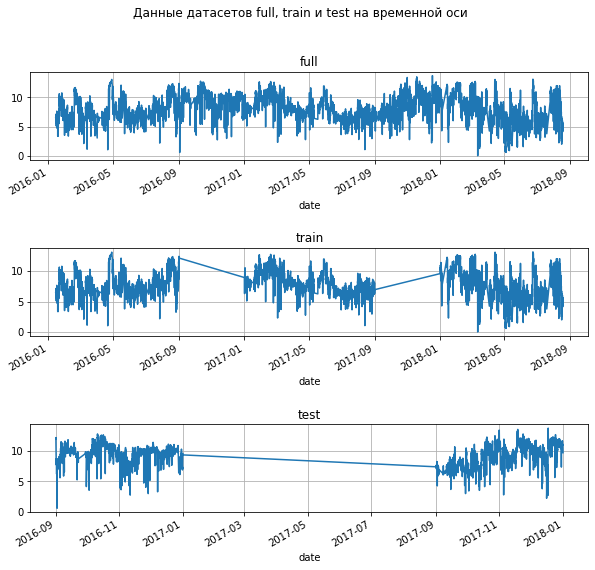

In [4]:
# построим три графика отображающие распределение данных full, train, test во времени
fig=plt.figure()
fig.suptitle('Данные датасетов full, train и test на временной оси')
fig.set_size_inches(10,9)

ax_1=fig.add_subplot(3,1,1)
ax_2=fig.add_subplot(3,1,2)
ax_3=fig.add_subplot(3,1,3)

ax_1.set_title('full')
ax_2.set_title('train')
ax_3.set(title = 'test')

full['rougher.input.feed_au'].plot(ax=ax_1, grid=True)
train['rougher.input.feed_au'].plot(ax=ax_2, grid=True)
test['rougher.input.feed_au'].plot(ax=ax_3, grid=True)


plt.subplots_adjust(hspace=1)
plt.show()

### Вывод

Нам даны три датасета. Набор признаков в двух из них идентичен - это full и train. В test содержится меньше признаков и нам предстоит выяснить почему. Данные описывают примерно одинаковый промежуток времени с января 2016 по сентябрь 2018. Если full это наиболее полный набор данных, то выбрки train и test это чередующиеся непересекающиеся временнЫе промежутки наблюдений. Количество наблюдений разное - самое полное в данных full. Можно подытожить:

   - при необходимости сопоставлять наблюдения из разных наборов следует сопоставлять их по временной метке;
   - если требуются данные для анализа, то взять их следует из full, как наиболее полного датасета;

Исходя из описания технологического процесса нашими целевыми признаками являются rougher.output.recovery и final.output.recovery. Нам нужно так преобразовать выборки train и test (с помощью full), чтобы на train можно было обучить модель, а на test проверить. 

В составе признаков присутствуют calculate-признаки. Следовало бы уточнить у технологов, что это за расчеты, не являются ли эти признаки dummy, то есть расчитанными на основе уже присутствующих в таблице данных. В данной работе примем допущение, что это дополнительно расчитанные признаки и их можно использовать в обучении модели.


## Проверка правильности расчета эффективности обогащения

Датасет train содержит расчитанный ранее признак rougher.output.recovery. Для того, чтобы быть уверенными в том, что дальнейший анализ не основан на ошибочных расчетах, перепроверим расчет показателя rougher.output.recovery. Применим формулу из описания технологического процесса и рассчитаем его заново. Посмотрим на среднюю абсолютную ошибку наших расчетов.

In [5]:
# верифицируемое значение эффективности обогащения
verifiable_recovery = train['rougher.output.recovery']

In [6]:
# значения ранее расчитанного признака
verifiable_recovery

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [7]:
# расчетное значение эффективности обогащения
calculated_recovery= 100 * (train['rougher.output.concentrate_au']/train['rougher.input.feed_au'])*\
(train['rougher.input.feed_au'] - train['rougher.output.tail_au'])/\
(train['rougher.output.concentrate_au'] - train['rougher.output.tail_au'])

In [8]:
# значения расчитанного нами признака
calculated_recovery

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

In [9]:
# считаем среднюю абсолютную ошибку
mean_absolute_error(verifiable_recovery, calculated_recovery)

1.18040035618949e-14

### Вывод

Значение среднего абсолютного отклонения мало. Значения расчитаны верно

## Анализ признаков, недоступных в тестовой выборке

Ранее мы обнаружили, что датасеты отличаются в том числе и по количеству признаков. Рассотрим в чем состоит это различие и как это влияет на наше исследование.

In [10]:
# full и train содержат одинаковый набор признаков 
full.columns.difference(train.columns)

Index([], dtype='object')

In [11]:
# выделим те признаки (колонки датасета), которые отсутствуют в test, 
# но присутствуют в train
train.columns.difference(test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

### Вывод

Обратим внимание на обозначение этапов технологического процесса в названиях признаков. Это:

    final.output (окончательные характеристики продукта)
    primary_cleaner.output (характеристики состава после первичной очистки)
    rougher.calculation (расчетные характеристики)
    rougher.output (характеристики состава после флотации)
    secondary_cleaner.output (характеристики состава после вторичной очистки)

Скорее всего в этих признаках заключены характеристики, появляющиеся уже в процессе обработки руды - *после* флотации, *после* первичной и вторичной очистки (в том числе и признаки rougher.output.recovery, final.output.recovery являющиеся целевыми).

Поскольку мы должны будем оценивать наши модели на test-выборке, то состав признаков в train-выборке и test-выборке должен быть идентичен. На данном этапе сохраним отстствующие в test признаки в переменной MISSED_FEATURES. Впоследствии, для того чтобы обучить модель уберем из train-выборки колонки переменной MISSED_FEATURES. Таким образом наша модель будет обучена на данных, известных только до старта процесса. А для проверки на test-выборке возьмем целевые признаки из full-датасета. Эти целевые признаки не будут совпадать с целевыми признаками из train, так как данные train и данные test это непересекающиеся множества.


In [12]:
# переменная MISSED_FEATURES хранит разницу в колонках выборок test и train
MISSED_FEATURES = list(train.columns.difference(test.columns))

##  Предобработка данных.

In [13]:
# Проверим данные на дубликаты
full.duplicated().sum()

0

In [14]:
train.duplicated().sum()

0

In [15]:
test.duplicated().sum()

0

Дубликаты отсутствуют

In [16]:
# проверим данные на пропуски
full.isna().sum().sum()

4481

In [17]:
train.isna().sum().sum()

4100

In [18]:
test.isna().sum().sum()

90

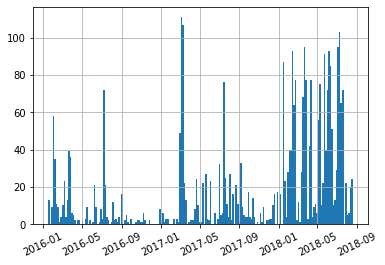

In [19]:
#посмотрим на распределение пропусков по всему объему данных выборка full
pd.Series(full.loc[full.isna().any(1)].index).hist(bins=200, xrot=25);

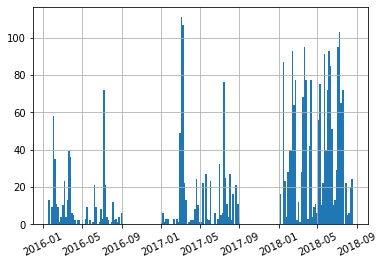

In [20]:
# посмотрим на распределение пропусков по всему объему данных выборка train
pd.Series(train.loc[train.isna().any(1)].index).hist(bins=200, xrot=25);

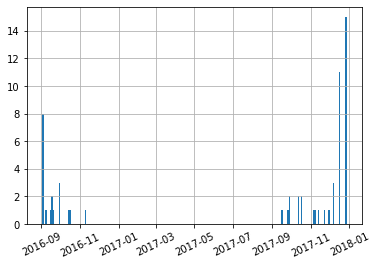

In [21]:
# посмотрим на распределение пропусков по всему объему данных выборка test
pd.Series(test.loc[test.isna().any(1)].index).hist(bins=200, xrot=25);

Объем пропусков значителен и составляет до 20-30% данных у full и train. Метод заполнения пропусков следует выбрать после консультаций с технологами. Как можно предположить из графиков распределения пропусков внутри данных, может иметь место значительное количество пропусков, *идущих подряд*. Мы можем предложить заполнение единичных пропусков предыдущим значением ('ffill'), методом ближайших средних (k-nearest) или средними значеними (mean). Для более протяженных гэпов совместно с технологами можно подобрать более сложный алгоритм заполнения. Для простоты воспользуемся методом 'ffill'.

In [22]:
# к каждому из наборов данных применим
full = full.fillna(method='ffill')
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')

In [23]:
# на примере full проверим как отработал метод
full.isna().sum().sum()

0

### Вывод

Данные в выборках full и train содержат большое количество пропусков - до 20-30%. Методы борьбы с ними (заполнение, исключение записей) во избежание привнесения "искусственности" в данные выбирается совместно с технологами производства. В данной работе мы остановились на методе заполнения предыдущм значением 'ffill', поскольку что сам характер технологического процесса говорит нам о том, что значения меняются постепенно, относительно плавно и каждое последующее обычно похоже на предыдущее значение.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
    
Данные подготовили, приступаем к анализу)
    
Для интереса, оставляю тебе ссылку, по флотации руды: https://www.youtube.com/watch?v=qYuGEjR8ZKw&t=13s


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Спасибо за ссылку. Мне в свое время помог понять что такое флотация этот фильм.
    

    
https://www.youtube.com/watch?v=BY9d1MC6qLs

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Пожалуйста) Посмотрю твою ссылку)

## Анализ данных

Для более глубокого понимания того, как меняется содержание золота в течение технологического процесса, исследуем его концентрацию совместно с другими элементами, содержащимися в руде - металлами (Au, Ag, Pb).
Концентрация золота на разных этапах очистки содержится в параметрах:

    rougher.input.feed_au - концентрация золота в руде
    rougher.output.concentrate_au - концентрация золота после флотации
    primary_cleaner.output.concentrate_au - концентрация золота после первичной очистки
    final.output.concentrate_au окончательная - концентрация золота

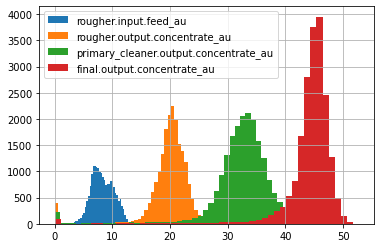

In [24]:
# построим гистограммы распределения концентрации золота по этапам технологического процесса
full['rougher.input.feed_au'].hist(bins=50, legend=True)
full['rougher.output.concentrate_au'].hist(bins=50, legend=True)
full['primary_cleaner.output.concentrate_au'].hist(bins=50, legend=True)
full['final.output.concentrate_au'].hist(bins=50, legend=True);

Концентрация свинца на разных этапах очистки содержится в параметрах:

    rougher.input.feed_pb - концентрация свинца в руде
    rougher.output.concentrate_pb - концентрация свинца после флотации
    primary_cleaner.output.concentrate_pb - концентрация свинца после первичной очистки
    final.output.concentrate_pb окончательная - концентрация свинца

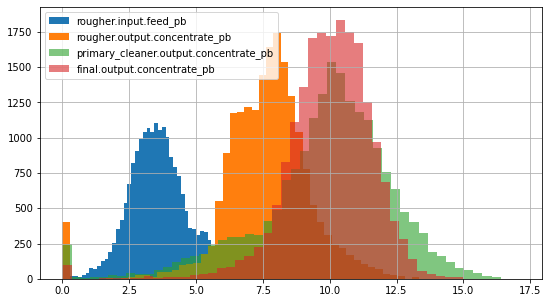

In [25]:
# построим гистограммы распределения концентрации свинца по этапам технологического процесса
full['rougher.input.feed_pb'].hist(bins=50, legend=True, figsize=(9,5))
full['rougher.output.concentrate_pb'].hist(bins=50, legend=True)
full['primary_cleaner.output.concentrate_pb'].hist(bins=50, legend=True, alpha=0.6)
full['final.output.concentrate_pb'].hist(bins=50, legend=True, alpha=0.6);

Концентрация серебра на разных этапах очистки содержится в параметрах:

    rougher.input.feed_ag - концентрация серебра в руде
    rougher.output.concentrate_ag - концентрация серебра после флотации
    primary_cleaner.output.concentrate_ag - концентрация серебра после первичной очистки
    final.output.concentrate_ag окончательная - концентрация серебра

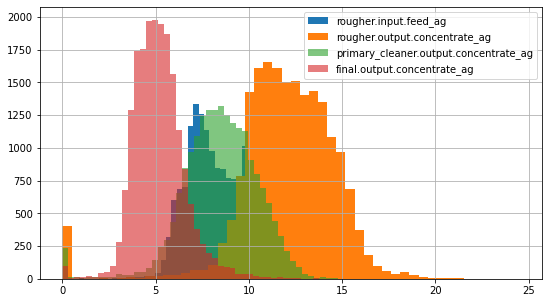

In [26]:
# построим гистограммы распределения концентрации серебра по этапам технологического процесса
full['rougher.input.feed_ag'].hist(bins=50, legend=True, figsize=(9,5))
full['rougher.output.concentrate_ag'].hist(bins=50, legend=True)
full['primary_cleaner.output.concentrate_ag'].hist(bins=50, legend=True, alpha=0.6)
full['final.output.concentrate_ag'].hist(bins=50, legend=True, alpha=0.6);

### Вывод

Сравнивая три графика можно отметить, что в отличие от остальных металлов, только концентрация у целевого продукта - золота - планомерно увеличивается от этапа к этапу. Это нам показывает ось Х. У оставшихся металлов концентрация незначительно растет после флотации (свинец - синий и желтый цвета), но в итоге все равно остается практически неизменной или даже снижается (серебро). Стоит отметить, что общей для всех веществ чертой является то, что по мере прохождения всех стадий процесса форма кривой вырастает и сужается. Это говорит об уменьшающемся разбросе значений каждого последующего измерения. Также можно отметить, что у каждого из компонентов есть некоторое количество наблюдений с концентрацией равной нулю.

## Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

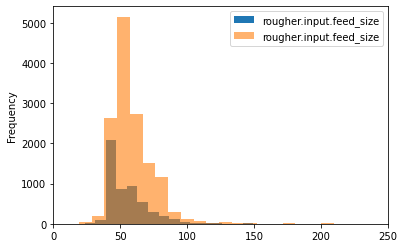

In [27]:
# построим гистограммы размера гранул сырья для тестовой и обучающей выборок
test['rougher.input.feed_size'].plot.hist(bins=50, legend=True, xlim=(0,250))
train['rougher.input.feed_size'].plot.hist(bins=50, alpha=.6, legend=True, xlim=(0,250));

In [28]:
# убедимся, что средние значения отличаются несущественно
train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [29]:
test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

### Вывод

Размеры гранул практически совпадают- ось Х. Вывод describe() показывает средний размер гранул 60 и 56 для train и test соответственно. Разница высоты графиков объясняется лишь тем, что в выборке test данных на треть меньше. Данные можно использовать для обучения и проверки модели.

## Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Попробуем отследить строки с аномальными значениями концентрации. Признаки, содержащие необходимые нам стадии и вещества следующие: 

- стадия сырья: **rougher.input.feed**, вещества (ag, pb, sol, au);
- стадия чернового концентрата: **rougher.output.concentrate**, вещества (ag, pb, sol, au);
- стадия финального концентрата: **final.output.concentrate**, вещества (ag, pb, sol, au).

Далее:
- создадим список необходимых нам колонок для каждой стадии;
- посмотрим распределение суммарных концентраций веществ на каждой стадии. 
- сделаем выводы

In [30]:
# создание списка
rougher_input_feed, rougher_output_concentrate, final_output_concentrate = [],[],[]
for col in train.columns:
    if 'rougher.input.feed' in col and 'size' not in col and 'rate' not in col:
        rougher_input_feed.append(col)
    elif 'rougher.output.concentrate' in col:
        rougher_output_concentrate.append(col)
    elif 'final.output.concentrate' in col:
        final_output_concentrate.append(col)

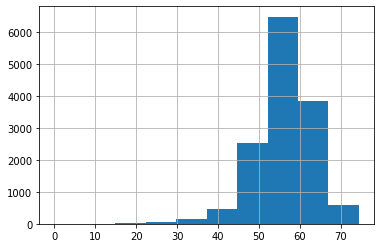

In [31]:
# распределение суммарных концентраций веществ на стадии сырья
train[rougher_input_feed].sum(axis=1).hist();

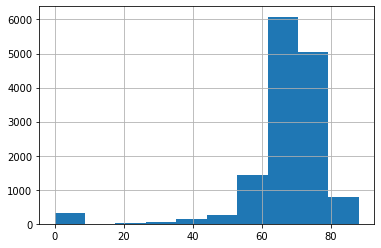

In [32]:
# распределение суммарных концентраций веществ на стадии чернового концентрата
train[rougher_output_concentrate].sum(axis=1).hist();

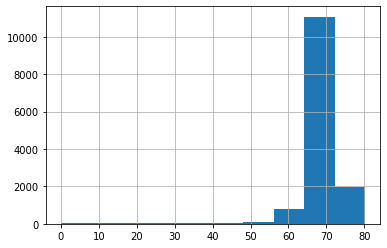

In [33]:
# распределение суммарных концентраций веществ на стадии финального концентрата
train[final_output_concentrate].sum(axis=1).hist();

Вывод:

На графике для стадии чернового концентрата видны нулевые значения. Значения концентраций веществ теоретически могут принимать сколь угодно малые значения, но их суммарная концентрация равная нулю - это явная аномалия. Такие строки нужно удалять. На графиках стадий сырья и финального концентрата нулевые значения не видны так явно, но они вполне могут быть. Необходимо удалять строки с нулевыми суммарными концентрациями и для этих стадий тоже.

In [34]:
print('Число строк до удаления', train.shape[0])

Число строк до удаления 14149


In [35]:
# удаление 
train = train.loc[(train[final_output_concentrate].sum(axis=1) != 0) & 
                  (train[rougher_input_feed].sum(axis=1) != 0) & 
                  (train[rougher_output_concentrate].sum(axis=1) != 0)]
print('Число строк после удаления', train.shape[0])

Число строк после удаления 13795


### Вывод

В дальнейшем мы планировали оценивать работу наших моделей на выборке test, используя целевые признаки из full. Однако, то что некоторые обучающте признаки неверны не значит, что целевой признак также ложен, ведь это не расчетные, а замеренные величины. Поэтому строки с аномальной суммой концентраций в full мы не проверяем, в отличии от выборки train, где они используются для обучения. 

То есть объекты, содержащие нули из выборки train мы удалили потому, что нули помешали бы обучить модели. А в датасете full мы оставили объекты с нулевыми концентрациями так как в этих объектах нам нужны будут только значения целевых признаков, которые мы "подставим" к соответствующим им по времени объектам из test.

## Напишем функцию для вычисления итоговой sMAPE

Эффективность обогащения рассчитывается по формуле

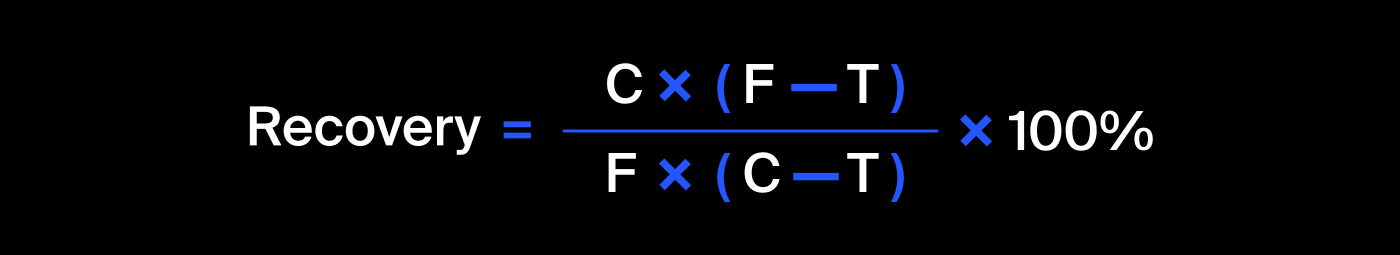

где:

    C — доля золота в концентрате после флотации/очистки;
    F — доля золота в сырье/концентрате до флотации/очистки;
    T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных, потому что, она одинаково учитывает масштаб и целевого признака, и предсказания.

Мы будем обсчитывать каждую стадию процесса отдельно. Сначала rougher, затем final. Напишем функцию для расчета sMAPE. Это позволит нам видеть метрики для каждой стадии в отдельности. Формула для нашей функции:

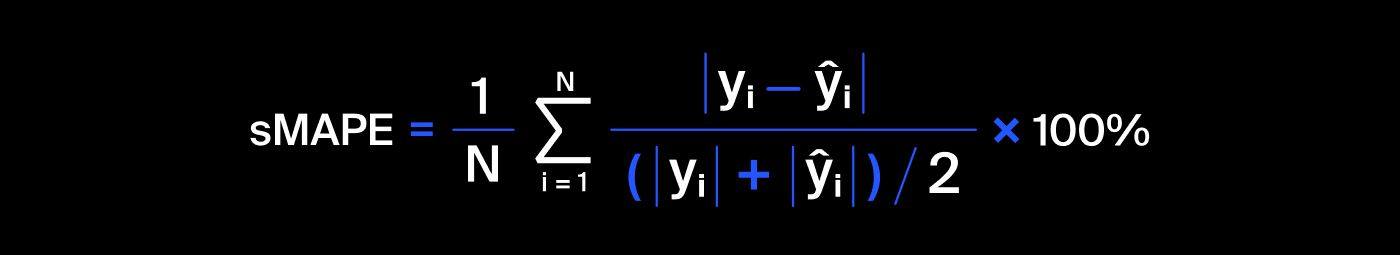

Обозначения:
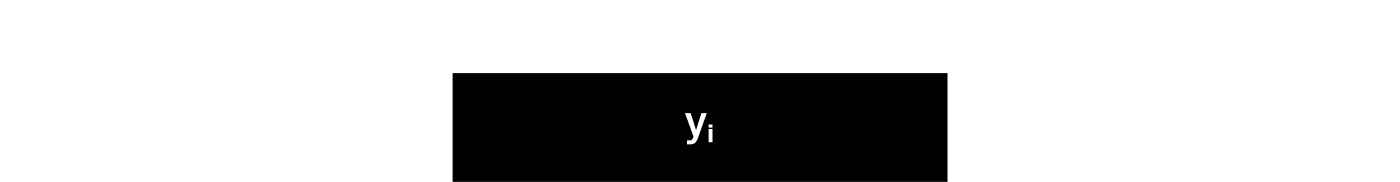

    Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.

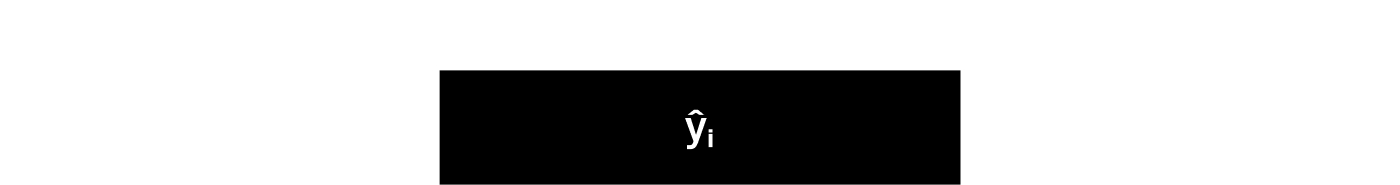

    Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.

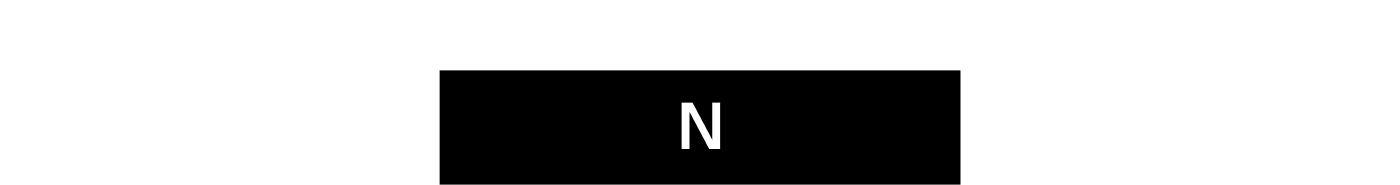

    Количество объектов в выборке.

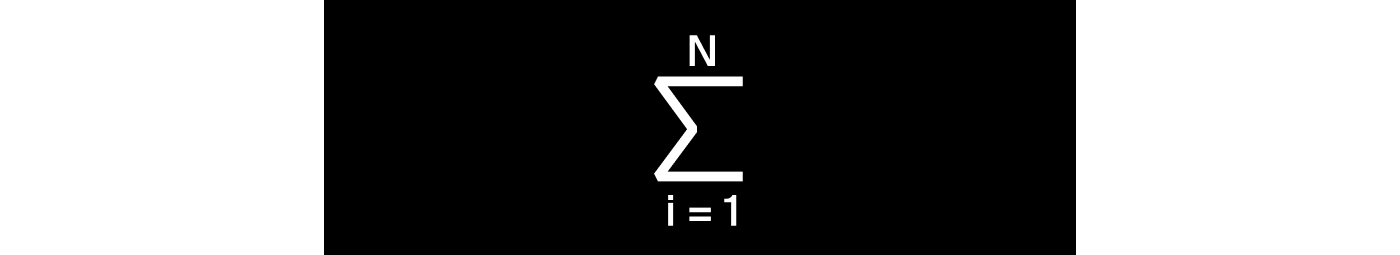

    Суммирование по всем объектам выборки (i меняется от 1 до N).

Нужно спрогнозировать сразу две величины:

    эффективность обогащения чернового концентрата rougher.output.recovery;
    эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

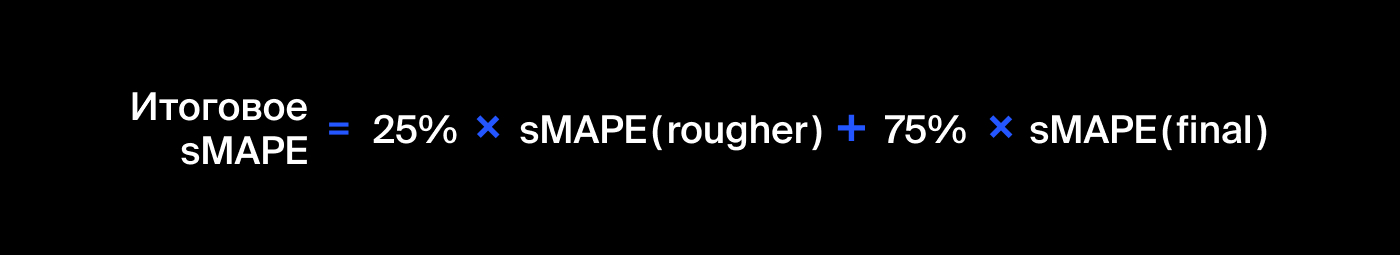

In [36]:
# функция для подсчета sMAPE (НЕ итоговой sMAPE)
def smape(target, predictions):
    error = np.abs(target - predictions)
# в знаменатель добавим константу, чтобы формула отрабатывала нулевые значения
    scale = 0.0000001 + (np.abs(target) + np.abs(predictions)) / 2
    return (error / scale).mean() * 100

In [37]:
# напишем простую функцию для расчета итоговой метрики принимающую в качестве аргументов метрики для rougher и final
def smape_final(smape_rougher, smape_final):
    return .25 * smape_rougher + .75 * smape_final

##  Подготовка выборок для обучения моделей

Наши данные прошли ранее этап предоработки: были удалены пропуски, аномалии. Однако, необходимо сделать еще несколько шагов до того, как их можно будет использовать для обучения моделей, предсказаний и оценки предсказаний, а именно:
1. выборка train
   - удалить признаки не присутствующие в выборке test (MISSED_FEATURES п.1.3.1);
   - удалить столбец date, который служил для нас индексом;
   - разделить на обучающие и целевые признаки;
   - выполнить масштабирование признаков;
   - разделить обучающие признаки на rougher и final.
2. выборка test
   - пока в выборке присутствует индекс date, нужно по нему подобрать соответствующие строки целевых признаков из full;
   - удалить столбец date, который служил для нас индексом;
   - разделить на обучающие и целевые признаки;
   - выполнить масштабирование признаков трансформером, обученным на train;
   - разделить обучающие признаки на rougher и final.

Выборка train

В списке MISSED_FEATURES есть два целевых признака, которые не нужно удалять из train. Удалим их из MISSED_FEATURES. 

In [38]:
# удалим из MISSED_FEATURES целевые признаки
MISSED_FEATURES.remove('rougher.output.recovery')
MISSED_FEATURES.remove('final.output.recovery')

In [39]:
# удаление MISSED_FEATURES из train
train = train.drop(columns=MISSED_FEATURES)

In [40]:
# теперь можно убедиться, что выборки test и train отличаются двумя целевыми признаками
train.columns.difference(test.columns)

Index(['final.output.recovery', 'rougher.output.recovery'], dtype='object')

In [41]:
# преобразуем date-index в обычный индекс
train = train.reset_index(drop=True)

In [42]:
# разделим train на обучающие и целевые признаки
train_target_rougher = train['rougher.output.recovery']
train_target_final = train['final.output.recovery']
train_features_final = train.drop(columns=['final.output.recovery', 
                                                'rougher.output.recovery'])
train_features_rougher = train[['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
       'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
       'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
       'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']]

In [43]:
# создадим объекты структуры StandardScaler() и настроим их на обучающих данных
# два объекта для обеих стадий
pd.options.mode.chained_assignment = None
scaler_rougher = StandardScaler()
scaler_rougher.fit(train_features_rougher)
scaler_final = StandardScaler()
scaler_final.fit(train_features_final)

StandardScaler()

In [44]:
# преобразуем с помощью обученного scaler сами данные
train_features_rougher = pd.DataFrame(scaler_rougher.transform(train_features_rougher), 
                                      columns=train_features_rougher.columns )
train_features_final = pd.DataFrame(scaler_final.transform(train_features_final),
                                   columns=train_features_final.columns)

Данные выборки train для работы с моделями готовы. Теперь подготовим выборку test.

Выборка test

In [45]:
# добавим в test целевые признаки из full:
# выполним слияние по date, который служит индексом в обоих таблицах
test = test.merge(full[['rougher.output.recovery','final.output.recovery']], on='date', how='left')

In [46]:
# в результате количество записей в test не изменилось, пропусков не появилось
# значит каждой записи test сопоставлена запись из full
test.isna().sum().sum()

0

In [47]:
# удалим столбец date из test, он нам больше не нужен, его заменит числовой индекс
test = test.reset_index(drop=True)

In [48]:
# отделим обучающие признаки от целевых
test_target_rougher = test['rougher.output.recovery']
test_target_final = test['final.output.recovery']
test_features_final = test.drop(columns = ['final.output.recovery', 
                                        'rougher.output.recovery'])
test_features_rougher = test[['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
       'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
       'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
       'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level']]

In [49]:
# преобразуем с помощью обученного scaler данные test_features
test_features_final = pd.DataFrame(scaler_final.transform(test_features_final),
                                  columns=test_features_final.columns)
test_features_rougher = pd.DataFrame(scaler_rougher.transform(test_features_rougher),
                                    columns=test_features_rougher.columns)

Данные выборки test для работы с моделями готовы.

## Построение прототипов моделей

В качестве метрик для моделей в данном исследовании используется формула, заключенная в функции smape(). Чтобы передать результат работы этой функции в функцию кросс-валидации в качестве переметра scoring, напишем scorer:

In [50]:
# scorer, через который значения метрик из smape() попадают в cross_val_score()
scorer = make_scorer(smape, greater_is_better=False)

Скорер для всех моделей выдает отрицательные значения так как мы используем параметр greater_is_better=False. Поэтому просто умножим результаты на -1.

### DecisionTreeRegressor

Перебор гиперпараметров моделей производится вручную.

Стадия rougher:

In [51]:
# наилучший результат модель показывает с параметрами max_depth менее 10
for depth in range(2,7,1):
    model_rougher_tree = DecisionTreeRegressor(max_depth=depth, random_state=888)
    scores_rougher_tree = cross_val_score(model_rougher_tree, train_features_rougher, train_target_rougher, 
                         scoring=scorer, cv=5)
    smape_rougher_tree = -1 * sum(scores_rougher_tree)/len(scores_rougher_tree)
    print('max_depth:', depth, '\n', 'sMAPE rougher tree:', smape_rougher_tree,)

max_depth: 2 
 sMAPE rougher tree: 7.46627753771039
max_depth: 3 
 sMAPE rougher tree: 7.1323163463635835
max_depth: 4 
 sMAPE rougher tree: 7.024134379969814
max_depth: 5 
 sMAPE rougher tree: 7.084423288177556
max_depth: 6 
 sMAPE rougher tree: 7.216671364605828


In [52]:
# остановимся на max_depth=4
smape_rougher_tree = 7.02

Стадия final:

In [53]:
# наилучший результат модель показывает с параметрами max_depth менее 10
for depth in range(1,5,1):
    model_final_tree = DecisionTreeRegressor(max_depth=depth, random_state=888)
    scores_final_tree = cross_val_score(model_final_tree, train_features_final, train_target_final, 
                         scoring=scorer, cv=5)
    smape_final_tree = -1 * sum(scores_final_tree)/len(scores_final_tree)
    print('max_depth:', depth, '\n', 'sMAPE final tree:', smape_final_tree,)

max_depth: 1 
 sMAPE final tree: 9.80465426862815
max_depth: 2 
 sMAPE final tree: 9.38611466180671
max_depth: 3 
 sMAPE final tree: 9.453212933724734
max_depth: 4 
 sMAPE final tree: 9.625554154202439


In [54]:
# остановимся на max_depth=2
smape_final_tree =  9.39

Итоговую метрику можно подсчитать по формуле:

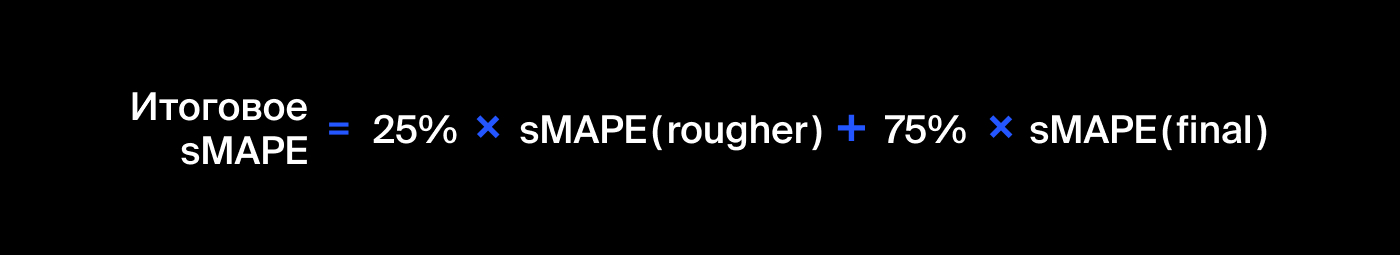

In [55]:
# итоговая sMAPE для DecisionTreeRegressor
smape_tree = smape_final(smape_rougher_tree, smape_final_tree)
smape_tree

8.7975

### RandomForestRegressor

Для подбора оптимальных параметров воспользуемся RandomizedSearchCV.

Стадия rougher:

In [56]:
# инициируем модель
model_rougher_forest = RandomForestRegressor(random_state=2345)

In [57]:
%%time
# перечислим параметры для оптимизации 
parameters = {'n_estimators': range (15,31,5), 
                  'min_samples_split': range (2,5), 
                  'max_depth': range (4,13,2), 
                  'min_samples_leaf': range (1,6)}

# создаем объект random_search c нашей моделью и параметрами
random_search =  RandomizedSearchCV(estimator = model_rougher_forest,
                                        param_distributions = parameters,
                                        cv = 3, 
                                        scoring = scorer, 
                                        n_jobs=3)

# обучаемся на данных rougher
random_search.fit(train_features_rougher, train_target_rougher)
best_parameters = random_search.best_params_
smape_rougher_forest = np.abs(random_search.best_score_)

CPU times: user 2.48 s, sys: 145 ms, total: 2.62 s
Wall time: 3min 6s


In [58]:
print('Оптимальные параметры стадии rougher:','\n', best_parameters)
print('Метрика cтадии rougher' , smape_rougher_forest)

Оптимальные параметры стадии rougher: 
 {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4}
Метрика cтадии rougher 7.762234772923365


Стадия final:

In [59]:
# инициируем модель
model_final_forest = RandomForestRegressor(random_state=2345)

In [60]:
%%time
# перечислим параметры для оптимизации 
parameters = {'n_estimators': range (15,26,5), 
                  'min_samples_split': range (2,5), 
                  'max_depth': range (4,11,2), 
                  'min_samples_leaf': range (1,6)}

# создаем объект random_search c нашей моделью и параметрами
random_search =  RandomizedSearchCV(estimator = model_final_forest,
                                        param_distributions = parameters,
                                        cv = 3, 
                                        scoring = scorer, 
                                        n_jobs=3)

# обучаемся на данных final
random_search.fit(train_features_final, train_target_final)
best_parameters = random_search.best_params_
smape_final_forest = np.abs(random_search.best_score_)

CPU times: user 4.61 s, sys: 29.5 ms, total: 4.64 s
Wall time: 6min 20s


In [61]:
print('Оптимальные параметры стадии final:','\n', best_parameters)
print('Метрика cтадии final' , smape_final_forest)

Оптимальные параметры стадии final: 
 {'n_estimators': 15, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 6}
Метрика cтадии final 10.675276685391403


In [62]:
# итоговая sMAPE для RandomForestRegressor
smape_forest = smape_final(smape_rougher_forest, smape_final_forest)
smape_forest

9.947016207274393

### LinearRegression

Стадия rougher:

In [63]:
model_rougher_rg = LinearRegression()
scores_rougher_rg = cross_val_score(model_rougher_rg, train_features_rougher, train_target_rougher, 
                         scoring=scorer, cv=5)
smape_rougher_rg = -1 * sum(scores_rougher_rg)/len(scores_rougher_rg)
print('sMAPE rougher linear regression:', smape_rougher_rg)

sMAPE rougher linear regression: 6.660435967486007


Стадия final:

In [64]:
model_final_rg = LinearRegression()
scores_final_rg = cross_val_score(model_final_rg, train_features_final, train_target_final, 
                         scoring=scorer, cv=5)
smape_final_rg = -1 * sum(scores_final_rg)/len(scores_final_rg)
print('sMAPE final linear regression:', smape_final_rg)

sMAPE final linear regression: 10.990200497449166


In [65]:
# итоговая sMAPE для LinearRegression
smape_rg = smape_final(smape_rougher_rg, smape_final_rg)
smape_rg

9.907759364958377

### Вывод

Модели показали следующие результаты по метрикам sMAPE:
- DecisionTreeRegressor: итоговая 8.79, rougher = 7.02, final = 9.39
- RandomForestRegressor: итоговая 9.93, rougher = 7.63, final = 10,7
- LinearRegression: итоговая 9.9, rougher = 6.66, final = 11

Предварительно можно отметить, что качество предсказаний не сильно зависело от выбора использованных нами гиперпараметров для моделей. Значения метрик, расчитанных разными моделями отличается незначительно.

Воспользуемся для расчета итоговой метрики sMAPE на выборке test моделью LinearRegression для стадии rougher. Модель производит расчеты быстрее остальных моделей, не требует подбора гиперпараметров, по точности расчета итоговой метрики уступает не сильно а для стадии rougher имеет лучший показатель. 

Для стадии final воспользуемся моделью DecisionTreeRegressor(max_depth=2), демонстрирующей лучший результат и ощутимо большую скорость по сравнению с RandomForestRegressor.

## Расчет sMAPE на выборке test

### Отобранные нами модели

Для стадии rougher мы отобрали модель LinearRegression, для стадии final DecisionTreeRegressor

In [66]:
# создадим модели
model_rougher_rg =LinearRegression()
model_final_tree = DecisionTreeRegressor(max_depth=2, random_state=888)


In [67]:
# обучим модели
model_rougher_rg.fit(train_features_rougher, train_target_rougher)
model_final_tree.fit(train_features_final, train_target_final)

DecisionTreeRegressor(max_depth=2, random_state=888)

In [68]:
# получим предсказания моделей:
predictions_rougher = pd.Series(model_rougher_rg.predict(test_features_rougher))
predictions_final = pd.Series(model_final_tree.predict(test_features_final))

In [69]:
# расчитаем метрику для обеих стадий rougher и final
smape_rougher_rg = smape(predictions_rougher, test_target_rougher)
smape_final_tree = smape(predictions_final, test_target_final)
print('метрика стадии rougher (линейная регрессия)', smape_rougher_rg)
print('метрика стадии final (дерево решений)', smape_final_tree)

метрика стадии rougher (линейная регрессия) 8.188480250355953
метрика стадии final (дерево решений) 9.923707516233145


Произведем расчет итоговой метрики sMAPE:

In [70]:
# итоговая метрика
final_sMAPE = smape_final(smape_rougher_rg, smape_final_tree)
final_sMAPE

9.489900699763847

### DummyRegressor

Для сравнения произведем расчет метрики технологического процесса прогнозируя показатели с помощью модели DummyRegressor.

In [71]:
# создаем модели
model_dummy_rougher =  DummyRegressor(strategy='median')
model_dummy_final =  DummyRegressor(strategy='median')

In [72]:
# обучаем на данных выборки train
model_dummy_rougher.fit(train_features_rougher, train_target_rougher)
model_dummy_final.fit(train_features_final, train_target_final)

DummyRegressor(strategy='median')

In [73]:
# получаем предсказания
predictions_rougher = pd.Series(model_dummy_rougher.predict(test_features_rougher))
predictions_final = pd.Series(model_dummy_final.predict(test_features_final))

In [74]:
# расчет метрики для стадии rougher
smape_rougher_dummy = smape(predictions_rougher, test_target_rougher)
smape_rougher_dummy

8.525870314847948

In [75]:
# расчет метрики для всего процесса
smape_final_dummy = smape(predictions_final, test_target_final)
smape_final_dummy

9.743369291462525

In [76]:
# расчет итоговой метрики для модели Dummy
final_sMAPE = smape_final(smape_rougher_dummy, smape_final_dummy)

In [77]:
# итоговая метрика для предсказаний модели Dummy
final_sMAPE

9.43899454730888

### Вывод

Метрика LinearRegression на выборке test (8.5) оказалась выше, чем на train выборке (6.66), из чего следует, что модель переобучилась. 
Метрика DecisionTreeRegressor на выборке test (9.74) осталась практически на пережнем уровне (9.39).
Общий показатель итоговой метрики (9.49) показал средний результат если сравнивать его с показателями исследованных моделей.
Однако он оказался хоть и несущественно но все же выше (хуже) Dummy модели (9.44).

## Общий вывод

Подготовка данных, а именно оформление обучающей и тестовой выборок, выбор целевых признаков, предобработка данных в данном исследовании составляет большую часть объема настоящего исследования и является определяющим для качества предсказаний моделей.

Перебор рассмотренных нами гиперпараметров дает десятые доли процентов прироста качества. Мне кажется, что причиной тому являются сама природа данных. Это числовые значения меняющиеся с течением времени относительно плавно и правильней всего для таких данных было бы использовать линейные модели. В том числе, именно из-за этой особенности данных наши модели работают на уровне константной модели.

Стоит отметить, что для всех моделей качество предсказания существенно падает с увеличением числа признаков: на rougher выборке sMAPE традиционно ниже у всех моделей чем на final выборке. То, в какой степени наблюдается это падение, может послужить критерием отбора той или иной модели.

Стоит упомянуть и о качестве самих предоставленных данных: существенное количество пропусков, в том числе идущих подряд, не могло не сказаться на качестве предсказаний моделей. Мне кажется в данном случае, пропуски стоило бы заполнять в соответствии со стратегией, принятой совместно с технологами - а тот, что мы применили, кажется мне слишком искусственным.